# Метод  линеаризованных лайков

Разобранными на лекции методами список того, что можно применять к метрикам-отношениям, не ограничивается. Есть огромное количество полезных материалов на эту темы. Начнем с [материалов](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3) Никиты Маршалкина. К слову, [вот](https://www.youtube.com/watch?v=gljfGAkgX_o&t=19s) его интервью, там тоже много интересного. 

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида 𝑥/𝑦

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» `CTR`, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного `CTR`), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских `CTR`

При этом метод сам по себе очень прост. Что это за метрика такая?

* Считаем общий `CTR` в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
* Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
* После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

**Задача**

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [34]:
import pandahouse
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(15, 10)})

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [4]:
%%time
# Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно
# Для эксперимента были задействованы 2 и 1 группы.
# В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.
q = """
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (0, 1, 2, 3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

CPU times: user 75.6 ms, sys: 7.55 ms, total: 83.1 ms
Wall time: 364 ms


In [5]:
df

,exp_group,user_id,likes,views,ctr
0,1,18392,7,32,0.218750
1,3,115383,12,44,0.272727
2,2,131473,9,108,0.083333
3,3,123580,2,11,0.181818
4,2,32420,13,44,0.295455
...,...,...,...,...,...
39814,0,27030,12,64,0.187500
39815,3,122758,20,118,0.169492
39816,1,132567,52,326,0.159509
39817,3,122190,19,65,0.292308


In [6]:
# Есть ли разница в среднем CTR и количестве просмотров?
df.groupby('exp_group').agg({'ctr': ['mean', 'median'], 'views': ['mean', 'median']})

ctr                views       
               mean    median       mean median
exp_group                                      
0          0.216858  0.205357  67.599194   58.0
1          0.216774  0.205882  66.820659   57.0
2          0.216102  0.153285  66.766630   57.0
3          0.233192  0.222222  66.884123   57.0

In [13]:
df_group_0 = df[df['exp_group'] == 0]
df_group_1 = df[df['exp_group'] == 1]
df_group_2 = df[df['exp_group'] == 2]
df_group_3 = df[df['exp_group'] == 3]

## Задача 1
Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

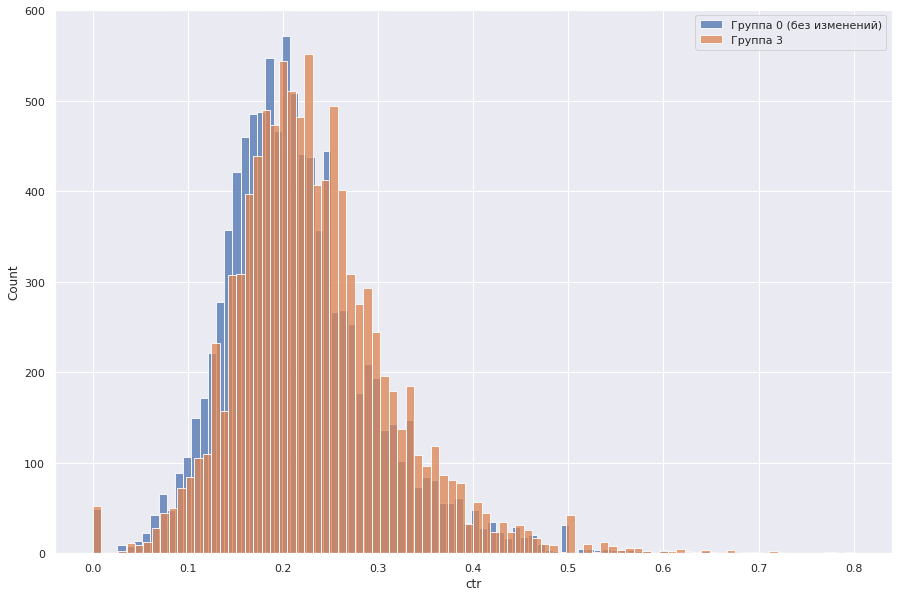

In [35]:
sns.histplot(df_group_0['ctr'], label='Группа 0 (без изменений)')
sns.histplot(df_group_3['ctr'], label='Группа 3')
plt.legend()
plt.show()

In [27]:
# Средние значения
df_group_0['ctr'].mean(), df_group_3['ctr'].mean()

(0.21685767434338885, 0.23319244373013098)

In [14]:
# t-test для групп 0 и 3
stats.ttest_ind(df_group_0['ctr'],
                df_group_3['ctr'],
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [25]:
# t-test для групп 0 и 3 с использованием линеаризованных лайков
# 1. Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
general_ctr_0 = df_group_0['likes'].sum() / df_group_0['views'].sum()

# 2. Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df_group_0['lin_likes'] = df_group_0['likes'] - general_ctr_0 * df_group_0['views']
df_group_3['lin_likes'] = df_group_3['likes'] - general_ctr_0 * df_group_3['views']

# 3. После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(df_group_0['lin_likes'],
                df_group_3['lin_likes'],
                equal_var=False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

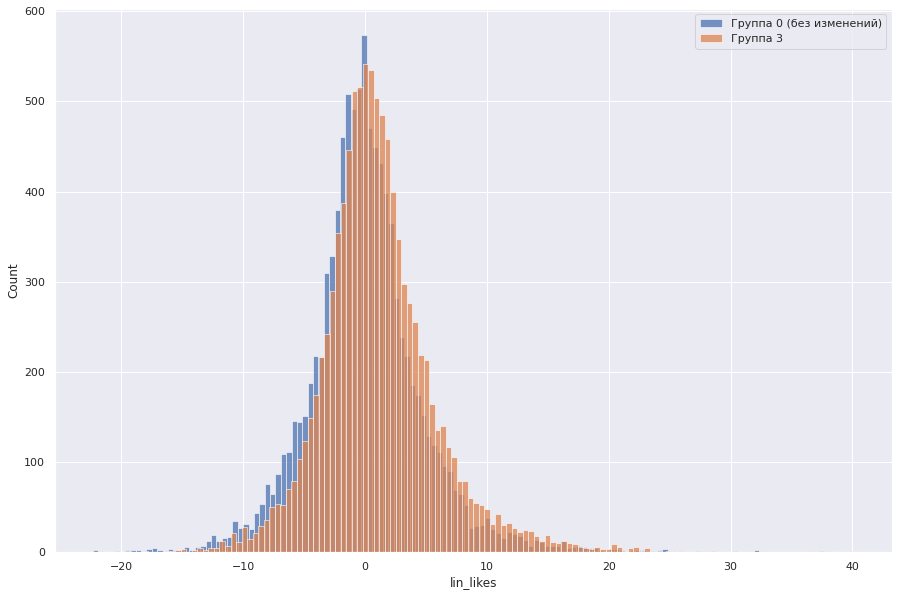

In [36]:
# Посмотрим на распределяни линеаризованных метрик
sns.histplot(df_group_0['lin_likes'], label='Группа 0 (без изменений)')
sns.histplot(df_group_3['lin_likes'], label='Группа 3')
plt.legend()
plt.show()

In [26]:
# Средние значения
df_group_0['lin_likes'].mean(), df_group_3['lin_likes'].mean()

(8.022256694065647e-17, 1.0948439641134204)

**Выводы**
1. CTR и linearized likes в группе 3 больше, чем в группе 0.
2. p-value стало меньше. Метрика linearized likes более чувствительная

## Задача 2

Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

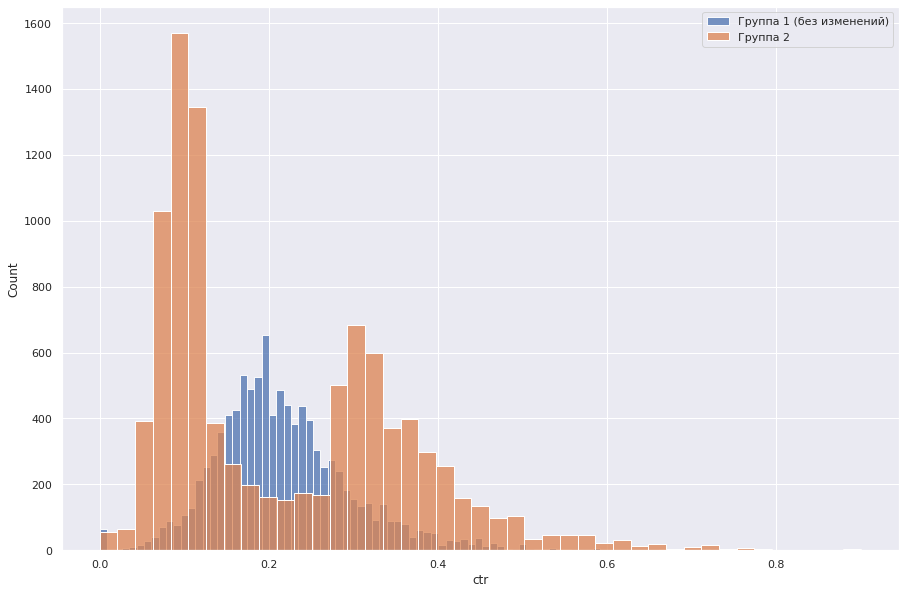

In [37]:
sns.histplot(df_group_1['ctr'], label='Группа 1 (без изменений)')
sns.histplot(df_group_2['ctr'], label='Группа 2')
plt.legend()
plt.show()

In [28]:
# Средние значения
df_group_1['ctr'].mean(), df_group_2['ctr'].mean()

(0.216773994120072, 0.2161016893237817)

In [29]:
# t-test для групп 1 и 2
stats.ttest_ind(df_group_1['ctr'],
                df_group_2['ctr'],
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [30]:
# t-test для групп 1 и 2 с использованием линеаризованных лайков
# 1. Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
general_ctr_1 = df_group_1['likes'].sum() / df_group_1['views'].sum()

# 2. Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
df_group_1['lin_likes'] = df_group_1['likes'] - general_ctr_1 * df_group_1['views']
df_group_2['lin_likes'] = df_group_2['likes'] - general_ctr_1 * df_group_2['views']

# 3. После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
stats.ttest_ind(df_group_1['lin_likes'],
                df_group_2['lin_likes'],
                equal_var=False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)

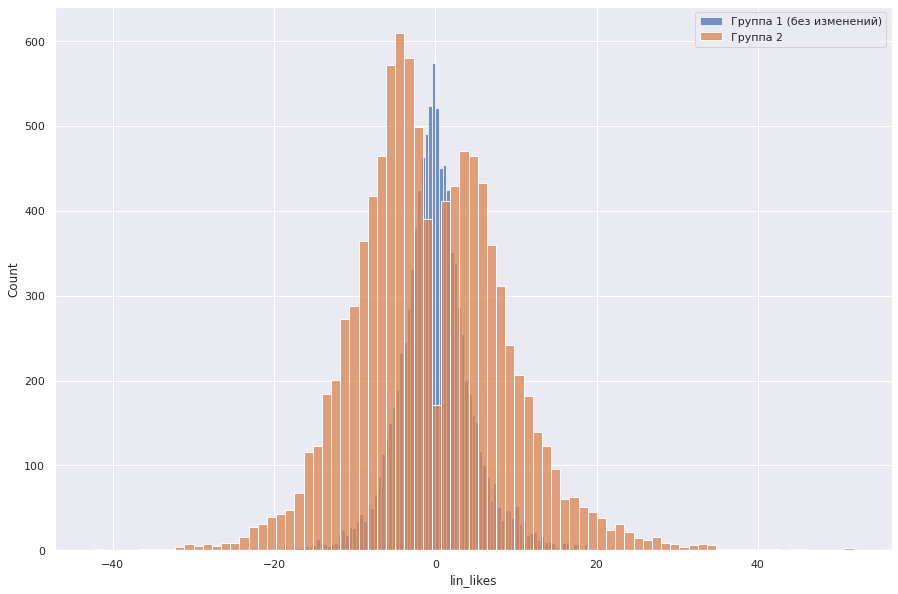

In [39]:
# Посмотрим на распределяни линеаризованных метрик
sns.histplot(df_group_1['lin_likes'], label='Группа 1 (без изменений)')
sns.histplot(df_group_2['lin_likes'], label='Группа 2')
plt.legend()
plt.show()

In [31]:
# Средние значения
df_group_1['lin_likes'].mean(), df_group_2['lin_likes'].mean()

(-2.723038029260264e-16, -0.6245118559393541)

**Выводы**
1. CTR и linearized likes в группе 1 больше, чем в группе 2 (там где алгоритм рекомендаций породил 2 группы пользователей).
2. p-value стало меньше. Метрика linearized likes более чувствительная